In [3]:
# %load ../helpers/header.py
# load ENV path to project from .profile 
import os, sys
PROJECT_ROOT_DIR=os.environ.get('ML_PATH')
sys.path.append(os.path.join(PROJECT_ROOT_DIR, "helpers")) # add helper modules to path

# MPL 
import MPL_header #load common MPL imports (from helpers)
import matplotlib.pyplot as plt
%matplotlib inline 
# %matplotlib widget 

# NP, constant seed, PD 
import numpy as np
np.random.seed(12345)
import pandas as pd

# Where to save the figures
SUB_DIR = "training"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "fig", SUB_DIR)
# IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "fig")
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Normal euation: $\theta = (X^TX)^{-1}X^Ty$

In [4]:
X = 2 * np.random.rand(100, 1)
y = 4 + 3 * X + np.random.randn(100, 1)

Saving figure generated_data_plot


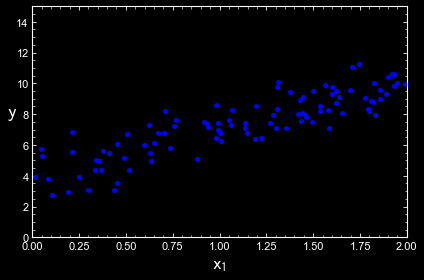

In [8]:
plt.style.use('dark_background')
plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([0, 2, 0, 15])
save_fig("generated_data_plot")
plt.show()

In [10]:
X_b = np.c_[np.ones((100, 1)), X]
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)

In [11]:
theta_best

array([[3.9801249 ],
       [3.05940348]])

In [12]:
X_new = np.array([[0], [2]])
X_new_b = np.c_[np.ones((2, 1)), X_new]
y_predict = X_new_b.dot(theta_best)
y_predict

array([[ 3.9801249 ],
       [10.09893186]])

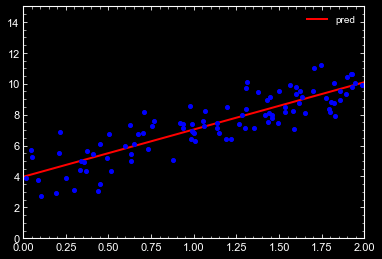

In [13]:
plt.style.use('dark_background')
plt.plot(X_new, y_predict, "r-", label="pred")
plt.plot(X, y, "b.")
plt.axis([0, 2, 0, 15]) 
plt.legend()
plt.show()

In [14]:
 from sklearn.linear_model import LinearRegression
 lin_reg = LinearRegression()
 lin_reg.fit(X, y)
 lin_reg.intercept_, lin_reg.coef_

(array([3.9801249]), array([[3.05940348]]))

In [15]:
 lin_reg.predict(X_new)

array([[ 3.9801249 ],
       [10.09893186]])

In [16]:
# the base method is just lstsq
theta_best_svd, residuals, rank, s = np.linalg.lstsq(X_b, y, rcond=1e-6)
theta_best_svd

array([[3.9801249 ],
       [3.05940348]])

In [17]:
 np.linalg.pinv(X_b).dot(y)

array([[3.9801249 ],
       [3.05940348]])

computational complexity $O(n^2)$ in features, $O(n)$ in instances

# Gradient Descent 
#### The learning step size is proportional to the slope of the cost function. Fortunately, since the cost function is convex in the case of Linear Regression. 
#### One muse ensure that all features have a similar scale (e.g. `StandardScaler`)

### Batch Gradient Descent (uses the whole batch of training data at every step (actually, Full Gradient Descent would probably be a better name)

In [18]:
eta = 0.1 # learning rate n_iterations = 1000 m=100
n_iterations = 1000
m=100

theta = np.random.randn(2,1) # random initialization

for iteration in range(n_iterations):
    gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y) 
    theta = theta - eta * gradients
theta

array([[3.9801249 ],
       [3.05940348]])

To find a good learning rate, you can use grid search; set a very large number of iterations but to interrupt the algorithm when the gradient vector becomes tiny—that is, when its norm becomes smaller than a tiny number ε (called the tolerance). it can take O(1/ε) iterations to reach the optimum within a range of ε, depending on the shape of the cost function. If you divide the tolerance by 10 to have a more precise solution, then the algorithm may have to run about 10 times longer.

# Stochastic Gradient Descent
picks a random instance in the training set at every step and computes the gradients based only on that single instance. When the cost function is very irregular, this can actually help the algorithm jump out of local minima, but bad because it means that the algorithm can never settle at the minimum

In [19]:
n_epochs = 50
t0, t1 = 5, 50 # learning schedule hyperparameters
def learning_schedule(t): 
    return t0/(t+t1)
theta = np.random.randn(2,1) # random initialization

for epoch in range(n_epochs): 
    for i in range(m):
        random_index = np.random.randint(m)
        xi = X_b[random_index:random_index+1]
        yi = y[random_index:random_index+1] 
        gradients = 2 * xi.T.dot(xi.dot(theta) - yi) 
        eta = learning_schedule(epoch * m + i) 
        theta = theta - eta * gradients
theta

array([[3.98526897],
       [3.07758368]])

If you want to be sure that the algorithm goes through every instance at each epoch, another approach is to shuffle the training set (making sure to shuffle the input features and the labels jointly), then go through it instance by instance, then shuffle it again, and so on. However, this approach generally converges more slowly.

In [20]:
from sklearn.linear_model import SGDRegressor
sgd_reg = SGDRegressor(max_iter=1000, tol=1e-3, penalty=None, eta0=0.1) 
sgd_reg.fit(X, y.ravel())
sgd_reg.intercept_, sgd_reg.coef_

(array([3.9710646]), array([3.07816823]))

# Mini-batch Gradient Descent
The main advantage of Mini-batch GD over Stochastic GD is that you can get a perfor‐ mance boost from hardware optimization of matrix operations, especially when using GPUs.

# Polynomial Regression

In [21]:
m=100
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X**2 + X + 2 + np.random.randn(m, 1)

Saving figure quadratic_data_plot


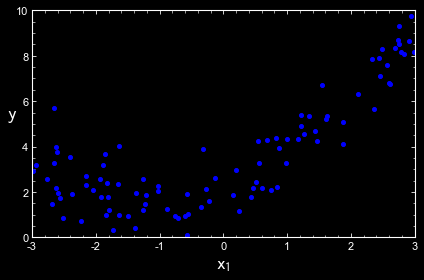

In [22]:
plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([-3, 3, 0, 10])
save_fig("quadratic_data_plot")
plt.show()

In [25]:
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)
X[0], X_poly[0]

(array([1.88240974]), array([1.88240974, 3.54346643]))

In [26]:
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)
lin_reg.intercept_, lin_reg.coef_

(array([2.07919506]), array([[1.00503752, 0.46760267]]))

Saving figure quadratic_predictions_plot


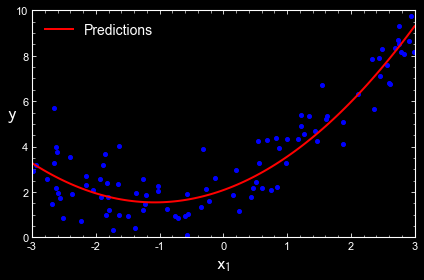

In [27]:
plt.style.use('dark_background')
X_new=np.linspace(-3, 3, 100).reshape(100, 1)
X_new_poly = poly_features.transform(X_new)
y_new = lin_reg.predict(X_new_poly)
plt.plot(X, y, "b.")
plt.plot(X_new, y_new, "r-", linewidth=2, label="Predictions")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=14)
plt.axis([-3, 3, 0, 10])
save_fig("quadratic_predictions_plot")
plt.show()

PolynomialFeatures(degree=d) transforms an array containing n features into an array containing (n + d)! / d!n! features, where n! is the factorial of n, equal to 1 × 2 × 3 × ⋯ × n. Beware of the combinatorial explosion of the number of features!

# Learning Curves
The model that will generalize best in this case is the quadratic model, which makes sense because the data was generated using a quadratic model. But in general you won’t know what function generated the data, so how can you decide how complex your model should be? How can you tell that your model is overfitting or underfitting the data? --> CV If a model performs well on the training data but generalizes poorly according to the cross-validation metrics, then your model is overfitting. If it per‐ forms poorly on both, then it is underfitting. This is one way to tell when a model is too simple or too complex.

Another way to tell is to look at the learning curves: these are plots of the model’s per‐ formance on the training set and the validation set as a function of the training set size (or the training iteration). 

In [20]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def plot_learning_curves(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2) 
    train_errors, val_errors = [], []
    
    for m in range(1, len(X_train)):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val) 
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict)) 
        val_errors.append(mean_squared_error(y_val, y_val_predict))

    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train") 
    plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="val")
    plt.legend(loc="upper right", fontsize=14)   # not shown in the book
    plt.xlabel("Training set size", fontsize=14) # not shown
    plt.ylabel("RMSE", fontsize=14)    

Saving figure underfitting_learning_curves_plot


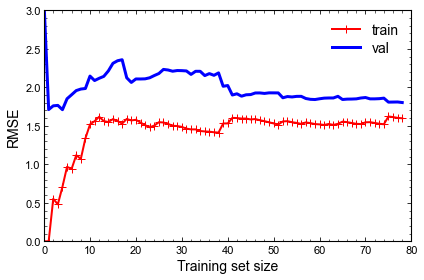

If your model is underfitting the training data, adding more training examples will not help. You need to use a more complex model or come up with better features.


In [21]:
lin_reg = LinearRegression()
plot_learning_curves(lin_reg, X, y)
plt.axis([0, 80, 0, 3])                         # not shown in the book
save_fig("underfitting_learning_curves_plot")   # not shown
plt.show()
print("If your model is underfitting the training data, adding more training examples will not help. You need to use a more complex model or come up with better features.")  

This means that the model performs signifi‐ cantly better on the training data than on the validation data, which is the hall‐ mark of an overfitting model. If you used a much larger training set, however, the two curves would continue to get closer.


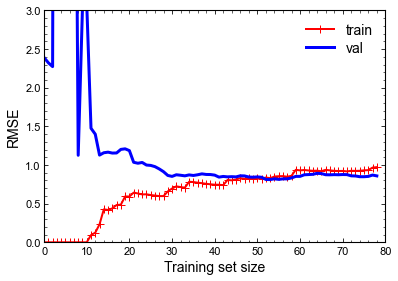

In [22]:
from sklearn.pipeline import Pipeline
polynomial_regression = Pipeline([
("poly_features", PolynomialFeatures(degree=10, include_bias=False)), ("lin_reg", LinearRegression()),
]) 
plot_learning_curves(polynomial_regression, X, y)
plt.axis([0, 80, 0, 3])
print("This means that the model performs signifi‐ cantly better on the training data than on the validation data, which is the hall‐ mark of an overfitting model. If you used a much larger training set, however, the two curves would continue to get closer.")

An important theoretical result of statistics and Machine Learning is the fact that a model’s generalization error can be expressed as the sum of three very different errors:

1) Bias: wrong assumption about the data

2) Variance: DoF -> overfitting 

3) Irreducible error: Noisines of data 

## Regularized Linear Models (constraining); not applied to the bias term ($\theta_0$)

### Ridge Regression [$l_2$] (Tikhonov regularization): $\propto \theta^2_i$ Note that the regularization term should only be added to the cost function during training

Apart from regularization, another reason they might be different is that a good training cost function should have optimization-friendly derivatives, while the performance measure used for testing should be as close as possible to the final objective. For example, classifiers are often trained using a cost function such as the log loss (dis‐ cussed in a moment) but evaluated using precision/recall.


In [23]:
from sklearn.linear_model import Ridge
ridge_reg = Ridge(alpha=1, solver="cholesky") 
ridge_reg.fit(X, y)
ridge_reg.predict([[1.5]])

array([[5.22017253]])

In [24]:
sgd_reg = SGDRegressor(penalty="l2")
sgd_reg.fit(X, y.ravel())
sgd_reg.predict([[1.5]])

array([5.19412444])

### Lasso Regression [$l_1$] $\propto |\theta_i|$ tends to eliminate the weights of the least important features

In [25]:
from sklearn.linear_model import Lasso
lasso_reg = Lasso(alpha=0.1)
lasso_reg.fit(X, y)
lasso_reg.predict([[1.5]])

array([5.17663534])

In [26]:
# same with SGD  
sgd_reg = SGDRegressor(penalty="l1")
sgd_reg.fit(X, y.ravel())
sgd_reg.predict([[1.5]])

array([5.20089635])

### Elastic Net: middle ground between l1 and l2

In [27]:
from sklearn.linear_model import ElasticNet
elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5)  # "50% l1 and 50$ l2"
elastic_net.fit(X, y)
elastic_net.predict([[1.5]])

array([5.17622053])

### Early Stopping "free lunch"

In [32]:
np.random.seed(42)
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 2 + X + 0.5 * X**2 + np.random.randn(m, 1)

X_train, X_val, y_train, y_val = train_test_split(X[:50], y[:50].ravel(), test_size=0.5, random_state=10)

In [33]:
from copy import deepcopy

poly_scaler = Pipeline([
        ("poly_features", PolynomialFeatures(degree=90, include_bias=False)),
        ("std_scaler", StandardScaler())
    ])

X_train_poly_scaled = poly_scaler.fit_transform(X_train)
X_val_poly_scaled = poly_scaler.transform(X_val)

sgd_reg = SGDRegressor(max_iter=1, tol=-np.infty, warm_start=True,
                       penalty=None, learning_rate="constant", eta0=0.0005, random_state=42)

minimum_val_error = float("inf")
best_epoch = None
best_model = None
for epoch in range(1000):
    sgd_reg.fit(X_train_poly_scaled, y_train)  # continues where it left off
    y_val_predict = sgd_reg.predict(X_val_poly_scaled)
    val_error = mean_squared_error(y_val, y_val_predict)
    if val_error < minimum_val_error:
        minimum_val_error = val_error
        best_epoch = epoch
        best_model = deepcopy(sgd_reg)

Saving figure early_stopping_plot


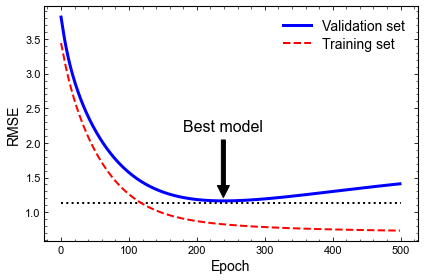

In [34]:
sgd_reg = SGDRegressor(max_iter=1, tol=-np.infty, warm_start=True,
                       penalty=None, learning_rate="constant", eta0=0.0005, random_state=42)

n_epochs = 500
train_errors, val_errors = [], []
for epoch in range(n_epochs):
    sgd_reg.fit(X_train_poly_scaled, y_train)
    y_train_predict = sgd_reg.predict(X_train_poly_scaled)
    y_val_predict = sgd_reg.predict(X_val_poly_scaled)
    train_errors.append(mean_squared_error(y_train, y_train_predict))
    val_errors.append(mean_squared_error(y_val, y_val_predict))

best_epoch = np.argmin(val_errors)
best_val_rmse = np.sqrt(val_errors[best_epoch])

plt.annotate('Best model',
             xy=(best_epoch, best_val_rmse),
             xytext=(best_epoch, best_val_rmse + 1),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.05),
             fontsize=16,
            )

best_val_rmse -= 0.03  # just to make the graph look better
plt.plot([0, n_epochs], [best_val_rmse, best_val_rmse], "k:", linewidth=2)
plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="Validation set")
plt.plot(np.sqrt(train_errors), "r--", linewidth=2, label="Training set")
plt.legend(loc="upper right", fontsize=14)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("RMSE", fontsize=14)
save_fig("early_stopping_plot")
plt.show()

## Logistic Regression $\sigma(\mathbf{x}^T\mathbf{\theta})$, sigmoid $\sigma=\frac{1}{1+e^{-t}}$

### Training and Cost Function

Saving figure logistic_function_plot


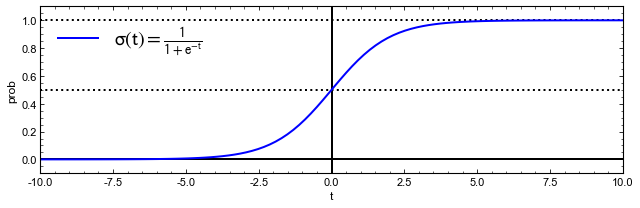

In [38]:
t = np.linspace(-10, 10, 100)
sig = 1 / (1 + np.exp(-t))
plt.figure(figsize=(9, 3))
plt.plot([-10, 10], [0, 0], "k-")
plt.plot([-10, 10], [0.5, 0.5], "k:")
plt.plot([-10, 10], [1, 1], "k:")
plt.plot([0, 0], [-1.1, 1.1], "k-")
plt.plot(t, sig, "b-", linewidth=2, label=r"$\sigma(t) = \frac{1}{1 + e^{-t}}$")
plt.xlabel("t")
plt.ylabel("prob")
plt.legend(loc="upper left", fontsize=20)
plt.axis([-10, 10, -0.1, 1.1])
save_fig("logistic_function_plot")
plt.show()

$t$ is logit, $\rm{logit(p)=log\left(\frac{p}{1-p}\right)}$. Cost function for y=1 -> $-log(\hat{p})$, and y=0 $-log(1-\hat{p})$

Decision Boundaries with irid datset using LogReg

In [39]:
from sklearn import datasets
iris = datasets.load_iris()
list(iris.keys())

['data',
 'target',
 'frame',
 'target_names',
 'DESCR',
 'feature_names',
 'filename']

In [40]:
print(iris.DESCR)

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

In [41]:
X = iris["data"][:, 3:]  # petal width
y = (iris["target"] == 2).astype(np.int)  # 1 if Iris virginica, else 0

In [42]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(solver="lbfgs", random_state=42)
log_reg.fit(X, y)

LogisticRegression(random_state=42)

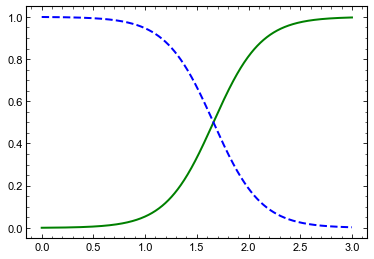

In [43]:
X_new = np.linspace(0, 3, 1000).reshape(-1, 1)
y_proba = log_reg.predict_proba(X_new)

plt.plot(X_new, y_proba[:, 1], "g-", linewidth=2, label="Iris virginica")
plt.plot(X_new, y_proba[:, 0], "b--", linewidth=2, label="Not Iris virginica")

Saving figure logistic_regression_plot


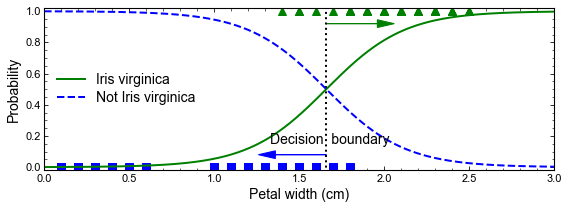

In [44]:
X_new = np.linspace(0, 3, 1000).reshape(-1, 1)
y_proba = log_reg.predict_proba(X_new)
decision_boundary = X_new[y_proba[:, 1] >= 0.5][0]

plt.figure(figsize=(8, 3))
plt.plot(X[y==0], y[y==0], "bs")
plt.plot(X[y==1], y[y==1], "g^")
plt.plot([decision_boundary, decision_boundary], [-1, 2], "k:", linewidth=2)
plt.plot(X_new, y_proba[:, 1], "g-", linewidth=2, label="Iris virginica")
plt.plot(X_new, y_proba[:, 0], "b--", linewidth=2, label="Not Iris virginica")
plt.text(decision_boundary+0.02, 0.15, "Decision  boundary", fontsize=14, color="k", ha="center")
plt.arrow(decision_boundary, 0.08, -0.3, 0, head_width=0.05, head_length=0.1, fc='b', ec='b')
plt.arrow(decision_boundary, 0.92, 0.3, 0, head_width=0.05, head_length=0.1, fc='g', ec='g')
plt.xlabel("Petal width (cm)", fontsize=14)
plt.ylabel("Probability", fontsize=14)
plt.legend(loc="center left", fontsize=14)
plt.axis([0, 3, -0.02, 1.02])
save_fig("logistic_regression_plot")
plt.show()

In [46]:
decision_boundary, log_reg.predict([[1.7], [1.5]])

(array([1.66066066]), array([1, 0]))

Saving figure logistic_regression_contour_plot


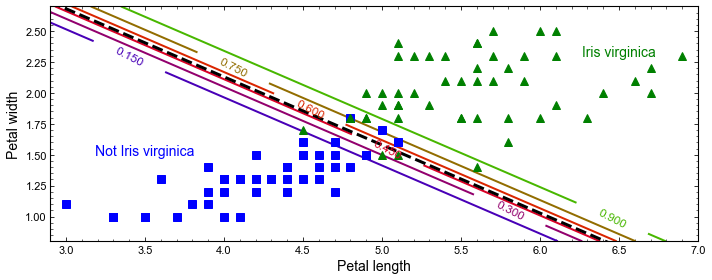

In [47]:
from sklearn.linear_model import LogisticRegression

X = iris["data"][:, (2, 3)]  # petal length, petal width
y = (iris["target"] == 2).astype(np.int)

log_reg = LogisticRegression(solver="lbfgs", C=10**10, random_state=42)
log_reg.fit(X, y)

x0, x1 = np.meshgrid(
        np.linspace(2.9, 7, 500).reshape(-1, 1),
        np.linspace(0.8, 2.7, 200).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]

y_proba = log_reg.predict_proba(X_new)

plt.figure(figsize=(10, 4))
plt.plot(X[y==0, 0], X[y==0, 1], "bs")
plt.plot(X[y==1, 0], X[y==1, 1], "g^")

zz = y_proba[:, 1].reshape(x0.shape)
contour = plt.contour(x0, x1, zz, cmap=plt.cm.brg)


left_right = np.array([2.9, 7])
boundary = -(log_reg.coef_[0][0] * left_right + log_reg.intercept_[0]) / log_reg.coef_[0][1]

plt.clabel(contour, inline=1, fontsize=12)
plt.plot(left_right, boundary, "k--", linewidth=3)
plt.text(3.5, 1.5, "Not Iris virginica", fontsize=14, color="b", ha="center")
plt.text(6.5, 2.3, "Iris virginica", fontsize=14, color="g", ha="center")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.axis([2.9, 7, 0.8, 2.7])
save_fig("logistic_regression_contour_plot")
plt.show()

### Softmax Regression (Multinomial Logistic Regression) $\sigma = \frac{e^s}{\sum e^s}$
The Softmax Regression classifier predicts only one class at a time (i.e., it is multiclass, not multioutput), so it should be used only with mutually exclusive classes, such as different types of plants. You cannot use it to recognize multiple people in one picture.

#### Cross-entroy is the CF for SofReg, and is == LogReg's CF for n=2

In [48]:
X = iris["data"][:, (2, 3)]  # petal length, petal width
y = iris["target"]

softmax_reg = LogisticRegression(multi_class="multinomial",solver="lbfgs", C=10, random_state=42)
softmax_reg.fit(X, y)

LogisticRegression(C=10, multi_class='multinomial', random_state=42)

In [51]:
#("Class with with petals that are 5 cm long and 2 cm wide")
 softmax_reg.predict([[5, 2]])

Class with with petals that are 5 cm long and 2 cm wide


In [54]:
softmax_reg.predict_proba([[5, 2]])
#"Iris virginica (class 2) with 94.3% probability (or Iris versicolor with 5.7% probability)")

array([[6.38014896e-07, 5.74929995e-02, 9.42506362e-01]])

Saving figure softmax_regression_contour_plot


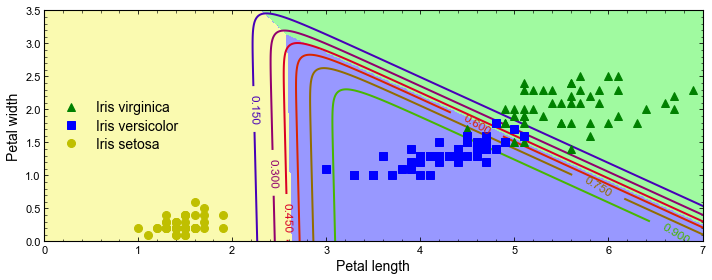

In [55]:
x0, x1 = np.meshgrid(
        np.linspace(0, 8, 500).reshape(-1, 1),
        np.linspace(0, 3.5, 200).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]


y_proba = softmax_reg.predict_proba(X_new)
y_predict = softmax_reg.predict(X_new)

zz1 = y_proba[:, 1].reshape(x0.shape)
zz = y_predict.reshape(x0.shape)

plt.figure(figsize=(10, 4))
plt.plot(X[y==2, 0], X[y==2, 1], "g^", label="Iris virginica")
plt.plot(X[y==1, 0], X[y==1, 1], "bs", label="Iris versicolor")
plt.plot(X[y==0, 0], X[y==0, 1], "yo", label="Iris setosa")

from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])

plt.contourf(x0, x1, zz, cmap=custom_cmap)
contour = plt.contour(x0, x1, zz1, cmap=plt.cm.brg)
plt.clabel(contour, inline=1, fontsize=12)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="center left", fontsize=14)
plt.axis([0, 7, 0, 3.5])
save_fig("softmax_regression_contour_plot")
plt.show()

Notice that the decision boundaries between any two classes are linear